<a href="https://colab.research.google.com/github/sudha240/Custom-CNN/blob/main/Velpuri_Sudha_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement**

> To build a CNN based model that detects Melanoma accurately.
  Melanoma is a type of cancer that can be deadly if not detected early.
> Melanoma accounts for 75% of skin cancer deaths.
> A solution that can evaluate images and alert dermatologists about the presence of this disease will have potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/CNN_assignment.zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)

In [3]:
#import libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.python.keras import layers
from keras.models import Sequential, load_model
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model

from glob import glob


**Data Reading/ Data Understanding**

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Create Dataset**

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                                              data_dir_train,
                                                              batch_size=batch_size,
                                                              image_size=(img_height,img_width),
                                                              label_mode='categorical',
                                                              validation_split=0.2,
                                                              subset="training",
                                                              seed=123
                                                             )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                                              data_dir_train,
                                                              batch_size=batch_size,
                                                              image_size=(img_height,img_width),
                                                              label_mode='categorical',
                                                              validation_split=0.2,
                                                              subset="validation",
                                                              seed=123
                                                             )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                                                data_dir_test,
                                                                batch_size=batch_size,
                                                                image_size=(img_height,img_width),
                                                                label_mode='categorical',
                                                                seed=123
                                                              )

Found 118 files belonging to 9 classes.


In [11]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Data Visualization**

code to visualize one instance of all the nine classes present in the dataset

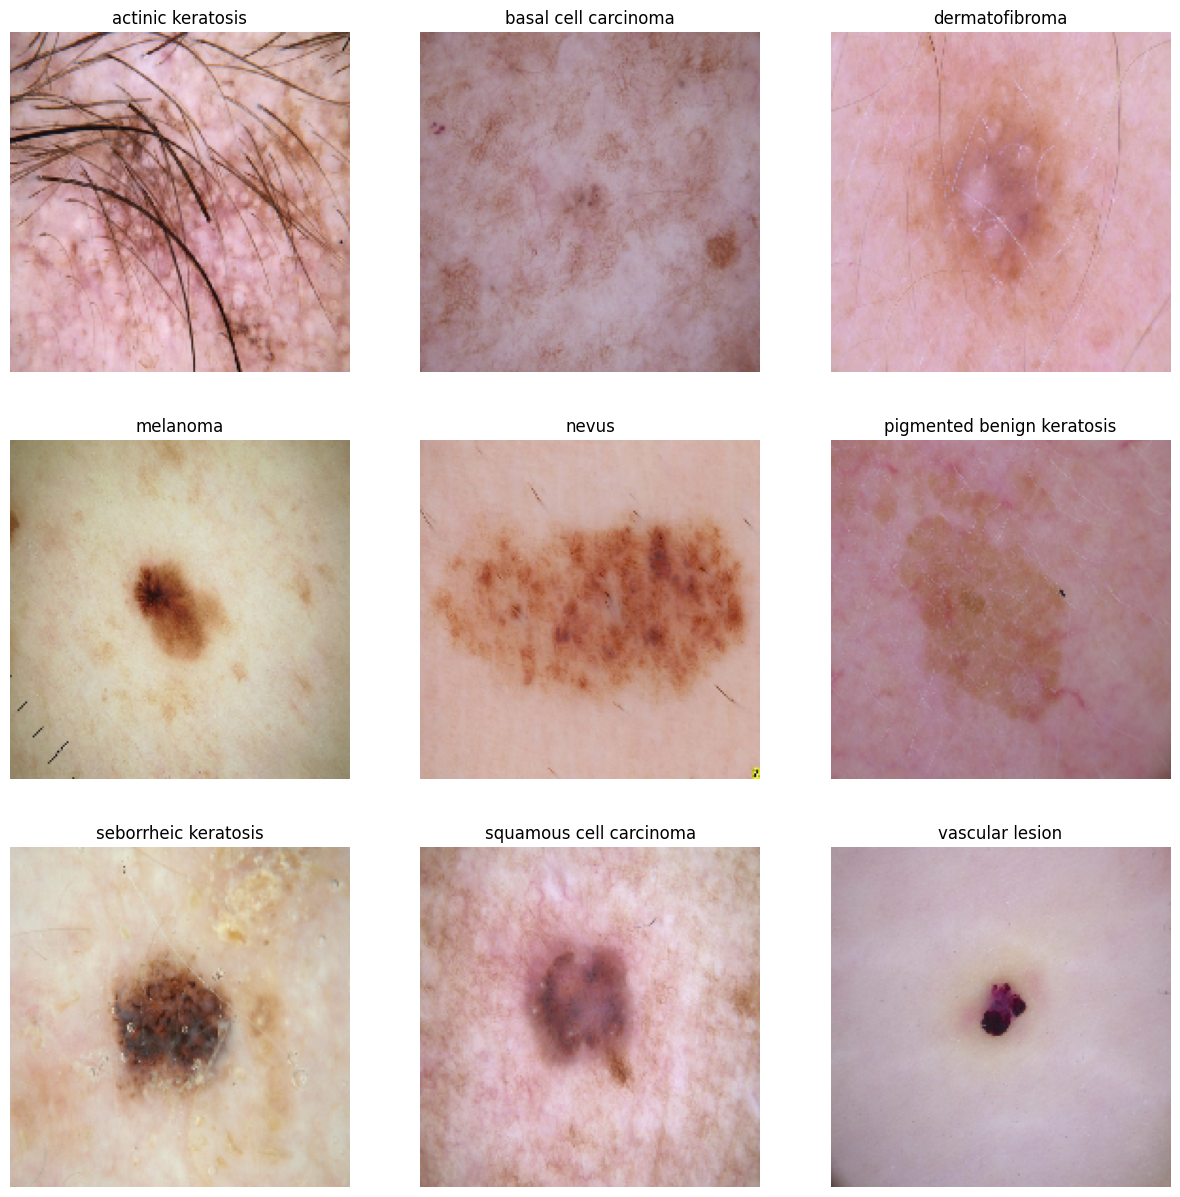

In [12]:
#Dictionary to store the path of image as per the class
files_path = {}

for c in class_names:
    files_path[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model**

> Todo:
Create a CNN model, which can accurately detect 9 classes present in the dataset.
Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1).
The RGB channel values are in the [0, 255] range.
This is not ideal for a neural network.
Here, it is good to standardize values to be in the [0, 1]

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [18]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.InputLayer(shape=(180, 180, 3)))

#Rescaling Layer to normalize pixel values between (0,1)
model.add(layers.Rescaling(1./255.))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 30% Fraction of the input units to drop.
model.add(layers.Dropout(0.30))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 30% Fraction of the input units to drop.
model.add(layers.Dropout(0.30))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

**Compile the model**
> Choose an appropirate optimiser and loss function for model training

In [20]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

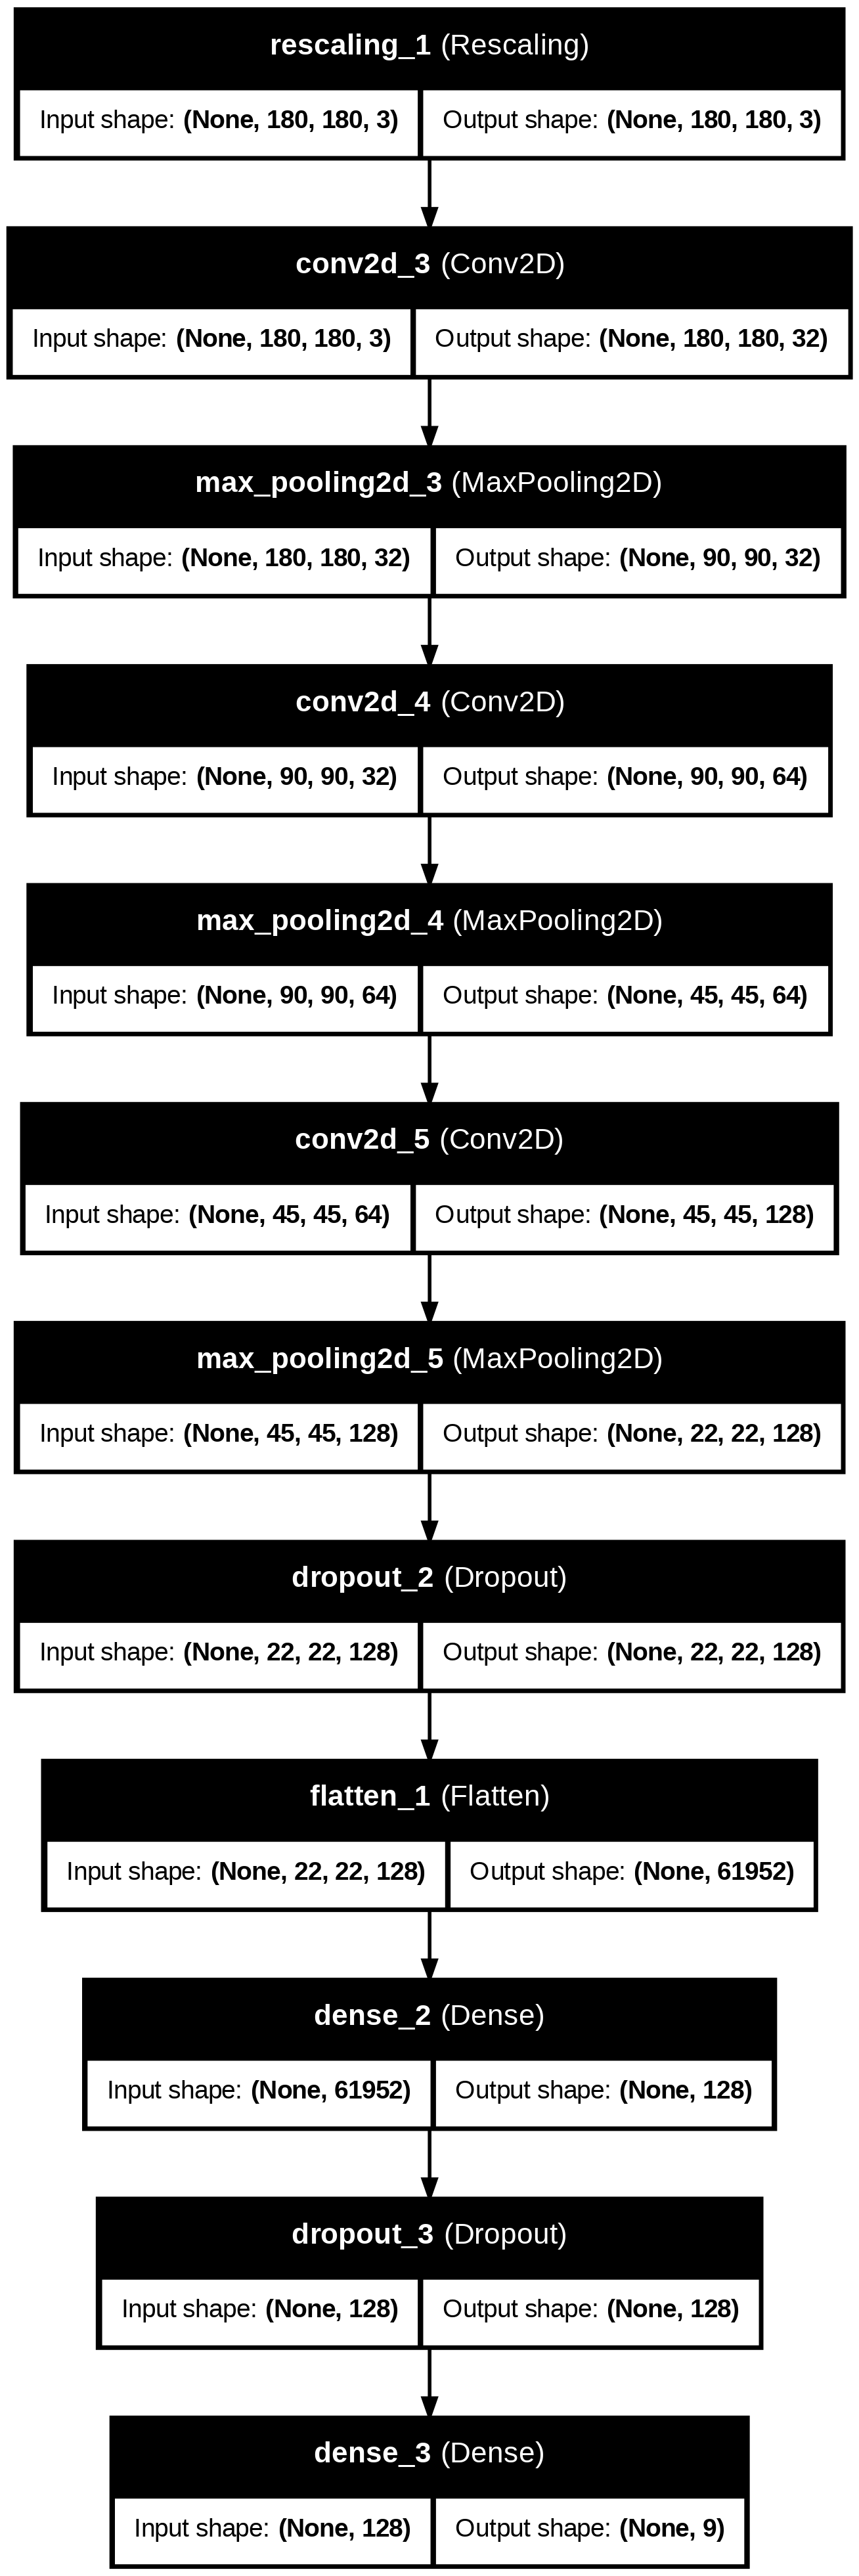

In [21]:
# vizualizing the model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Train the model**

In [22]:
#train the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.1956 - loss: 2.5461 - val_accuracy: 0.3043 - val_loss: 1.9038
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.3146 - loss: 1.8660 - val_accuracy: 0.4631 - val_loss: 1.6629
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.4450 - loss: 1.5810 - val_accuracy: 0.5011 - val_loss: 1.4659
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.4542 - loss: 1.5235 - val_accuracy: 0.5414 - val_loss: 1.4109
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.5402 - loss: 1.3384 - val_accuracy: 0.5280 - val_loss: 1.3464
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.5535 - loss: 1.2904 - val_accuracy: 0.5235 - val_loss: 1.3774
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.5414 - loss: 1.2893 - val_accuracy: 0.5302 - val_loss: 1.3297
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.5764 - loss: 1.1838 - val_accuracy: 0.5145 - v

**Visualizing training results**

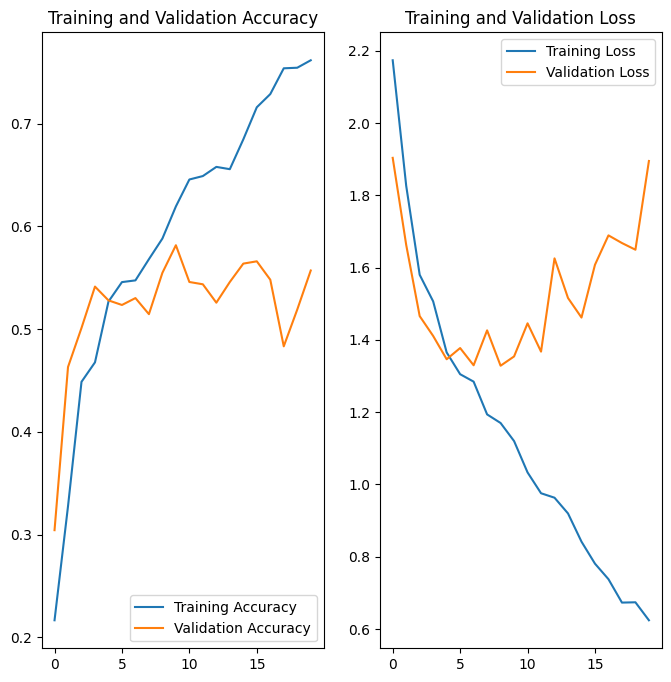

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observation**

> Training accuracy is high(.8793) and loss is low(0.31) whereas Validation accuracy is near to training accuracy(.82) and loss is high(0.68). This means model is not performing well on unseen data and is case of overfitting.



**Data Augmentation - Manual**

In [30]:
!pip install Augmentor

In [31]:
from tensorflow import keras
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator rotation
datagen = ImageDataGenerator(
                                rotation_range=30,
                                fill_mode='nearest',
                                rescale=1.0/255.0,
                                validation_split=0.2
                             )


In [38]:
data_dir_manual_aug = "/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train"

In [39]:
class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [40]:
train_ds_manual_aug = datagen.flow_from_directory(
                                            data_dir_manual_aug,
                                            target_size = (img_height, img_width),
                                            classes = class_names,
                                            batch_size = batch_size,
                                            subset="training",
                                            seed=123
                                          )

Found 1795 images belonging to 9 classes.


In [41]:
val_ds_manual_aug = datagen.flow_from_directory(
                                            data_dir_manual_aug,
                                            target_size = (img_height, img_width),
                                            classes = class_names,
                                            batch_size = batch_size,
                                            subset="validation",
                                            seed=123
                                          )

Found 444 images belonging to 9 classes.


In [42]:
## Create the model

model_manual_aug = Sequential()

model_manual_aug.add(layers.InputLayer(shape=(180, 180, 3)))

#Rescaling Layer to normalize pixel values between (0,1)
model_manual_aug.add(layers.Rescaling(1.0/255.00))

#First Convulation layer
model_manual_aug.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding='same'))
model_manual_aug.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model_manual_aug.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'))
model_manual_aug.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model_manual_aug.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding='same'))
model_manual_aug.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 30% Fraction of the input units to drop.
model_manual_aug.add(layers.Dropout(0.30))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model_manual_aug.add(layers.Flatten())

#Dense Layer
model_manual_aug.add(layers.Dense(128,activation='relu'))

#Dropout layer with 30% Fraction of the input units to drop.
model_manual_aug.add(layers.Dropout(0.30))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model_manual_aug.add(layers.Dense(len(class_names),activation='softmax'))

In [43]:
# View the summary of all layers
model_manual_aug.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# compile the model
model_manual_aug.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [45]:
#train the model
epochs = 20
history_manual_aug = model_manual_aug.fit(
                                            train_ds_manual_aug,
                                            #batch_size=batch_size,
                                            validation_data=val_ds_manual_aug,
                                            epochs=epochs
                                          )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.1692 - loss: 2.0900 - val_accuracy: 0.2072 - val_loss: 2.0166
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.2219 - loss: 2.0338 - val_accuracy: 0.2072 - val_loss: 2.0154
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.1905 - loss: 2.0302 - val_accuracy: 0.2072 - val_loss: 2.0140
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.2059 - loss: 2.0193 - val_accuracy: 0.1959 - val_loss: 2.0169
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.2067 - loss: 2.0353 - val_accuracy: 0.1689 - val_loss: 2.0195
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.2022 - loss: 2.0468 - val_accuracy: 0.2072 - val_loss: 2.0127
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.2022 - loss: 2.0388 - val_accuracy: 0.2072 - val_loss: 2.0207
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.1668 - loss: 2.0403 - val_accuracy: 0.2072 - v

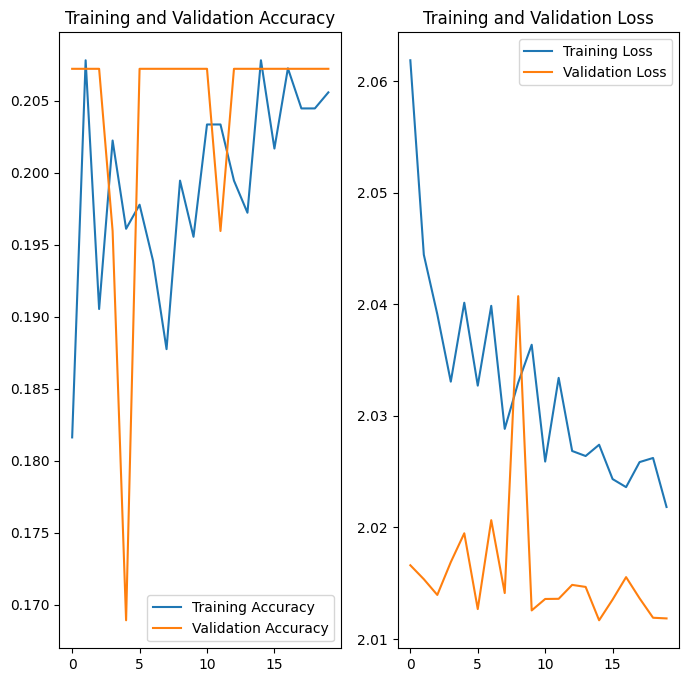

In [46]:
acc = history_manual_aug.history['accuracy']
val_acc = history_manual_aug.history['val_accuracy']

loss = history_manual_aug.history['loss']
val_loss = history_manual_aug.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observation**

> Rotation of images to 30 degree didn't help, very low accuracy and high loss on both training and validation. This means model is not performing well on both seen and unseen data and is case of underfitting.

**Class Distribution**

In [47]:
#Find the distribution of classes in the training dataset
path_list=[]
lesion_list=[]
for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    path_list.append(str(j))
    lesion_list.append(i)

In [48]:
dataframe_dict = dict(zip(path_list, lesion_list))

In [49]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
print(original_df.Label.value_counts())

Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64


Text(0.5, 1.0, 'Image Count per Class')

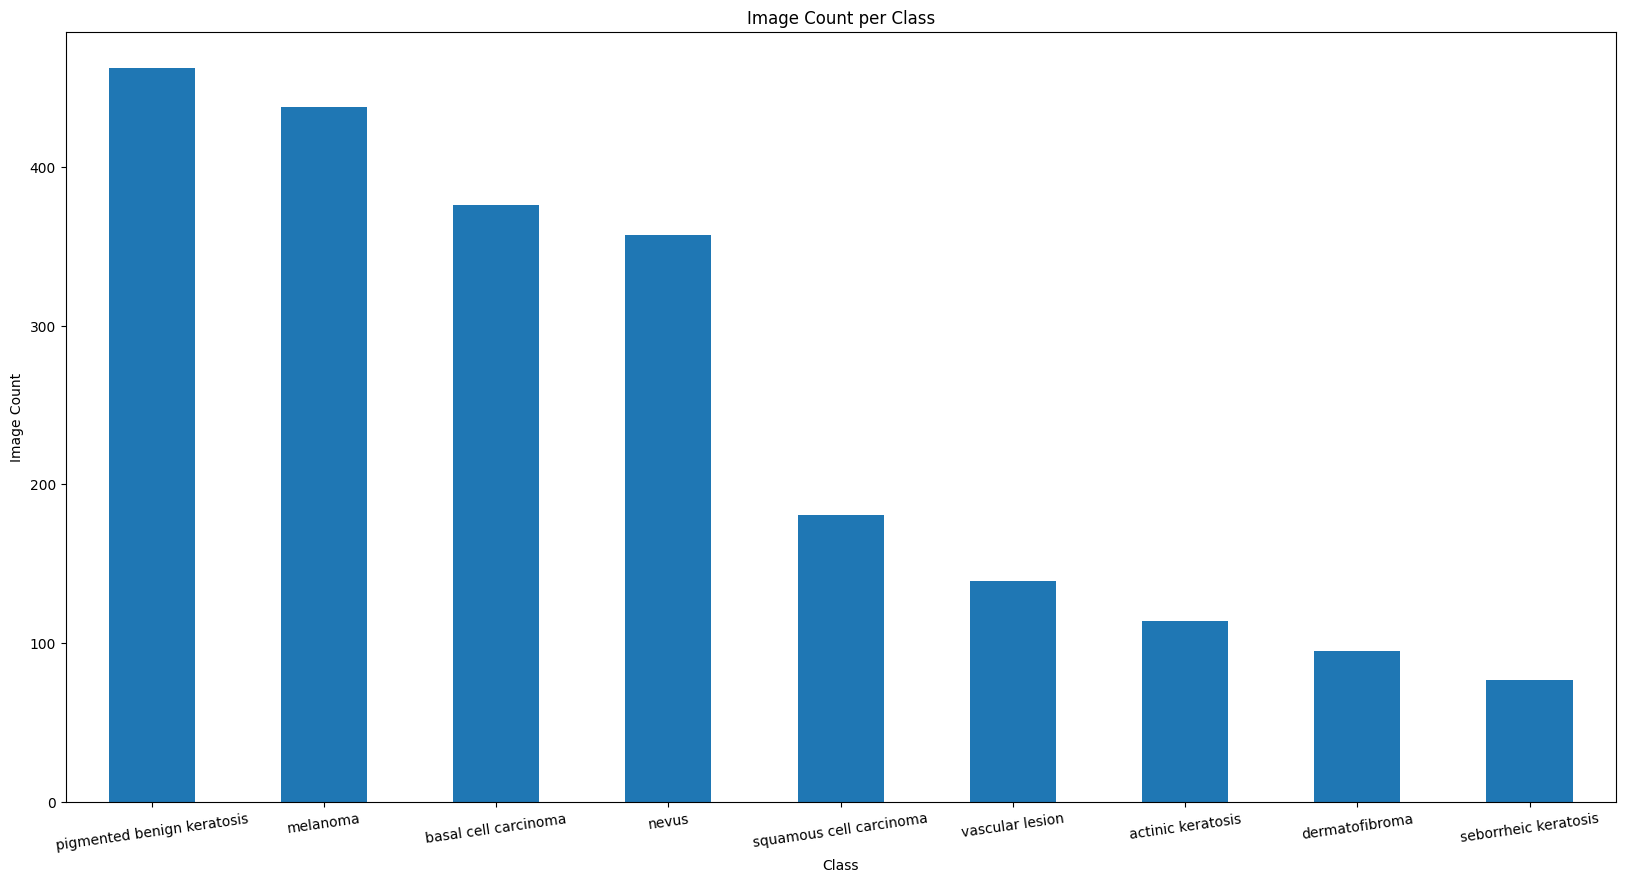

In [50]:
#visualize the class class distribution

original_df.Label.value_counts().plot(kind='bar', figsize=(20, 10), rot=8)
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.title("Image Count per Class")

**Observation**

*   seborrheic keratosis class has the least number of samples
*   melanoma and basal cell carcinoma classes dominate the data in terms proportionate number of samples

**Handling class imbalances**

In [51]:
path_to_training_dataset="/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C4E8B5A2AD0>: 100%|██████████| 500/500 [00:16<00:00, 30.14 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C4E8BDEE990>: 100%|██████████| 500/500 [00:17<00:00, 28.44 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C4E8B6417D0>: 100%|██████████| 500/500 [00:18<00:00, 27.74 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C4E8BD2E950>: 100%|██████████| 500/500 [01:36<00:00,  5.17 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C4E8BEC7050>: 100%|██████████| 500/500 [01:30<00:00,  5.54 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C4E8BCC7C10>: 100%|██████████| 500/500 [00:17<00:00, 28.32 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C4E8B590E90>: 100%|██████████| 500/500 [00:41<00:00, 11.93 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C4E8BEB19D0>: 100%|██████████| 500/500 [00:16<00:00, 29.60 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C4E9461D6D0>: 100%|██████████| 500/500 [00:18<00:00, 26.71 Samples/s]


**Note:** Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [52]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Next Action**

Lets see the distribution of augmented data after adding new images to the original training data.

In [53]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030555.jpg_e53d8148-4431-48d0-adbc-bd2b0e335008.jpg',
 '/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026471.jpg_d89f1035-6f3e-42ee-9da7-b95dc856007f.jpg',
 '/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029248.jpg_8bbdcb76-defb-4ee3-85b4-b27d9536221f.jpg',
 '/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025622.jpg_f474a6c3-e03d-4e73-9bcc-090dc7cefd43.jpg',
 '/content/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031799.jpg_5d1951da-aa1d-4482-baef-be8637354484.jpg',
 '/content/dataset/Skin cancer ISIC

In [54]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [55]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [57]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

# Concatenate the original_df with df2
new_df = pd.concat([original_df, df2], ignore_index=True)
new_df['Label'].value_counts()

# Check the value counts of 'Label' column
print(new_df['Label'].value_counts())

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64


**Train the model on the data created using Augmentor**

In [58]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                                                data_dir_train,
                                                                seed=123,
                                                                validation_split = 0.2,
                                                                subset = "training",
                                                                image_size = (img_height, img_width),
                                                                batch_size = batch_size
                                                               )

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [59]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                                              data_dir_train,
                                                              seed=123,
                                                              validation_split = 0.2,
                                                              subset = "validation",
                                                              image_size=(img_height, img_width),
                                                              batch_size=batch_size
                                                             )

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [60]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model_Augmentor = Sequential()

model_Augmentor.add(layers.InputLayer(shape=(180, 180, 3)))

#Rescaling Layer to normalize pixel values between (0,1)
model_Augmentor.add(layers.Rescaling(1.0/255.00))

#First Convulation layer
model_Augmentor.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding='same'))
model_Augmentor.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model_Augmentor.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'))
model_Augmentor.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model_Augmentor.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding='same'))
model_Augmentor.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 30% Fraction of the input units to drop.
model_Augmentor.add(layers.Dropout(0.30))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model_Augmentor.add(layers.Flatten())

#Dense Layer
model_Augmentor.add(layers.Dense(128,activation='relu'))

#Dropout layer with 30% Fraction of the input units to drop.
model_Augmentor.add(layers.Dropout(0.30))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model_Augmentor.add(layers.Dense(len(class_names),activation='softmax'))

In [61]:
# View the summary of all layers
model_Augmentor.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# compile the model
model_Augmentor.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

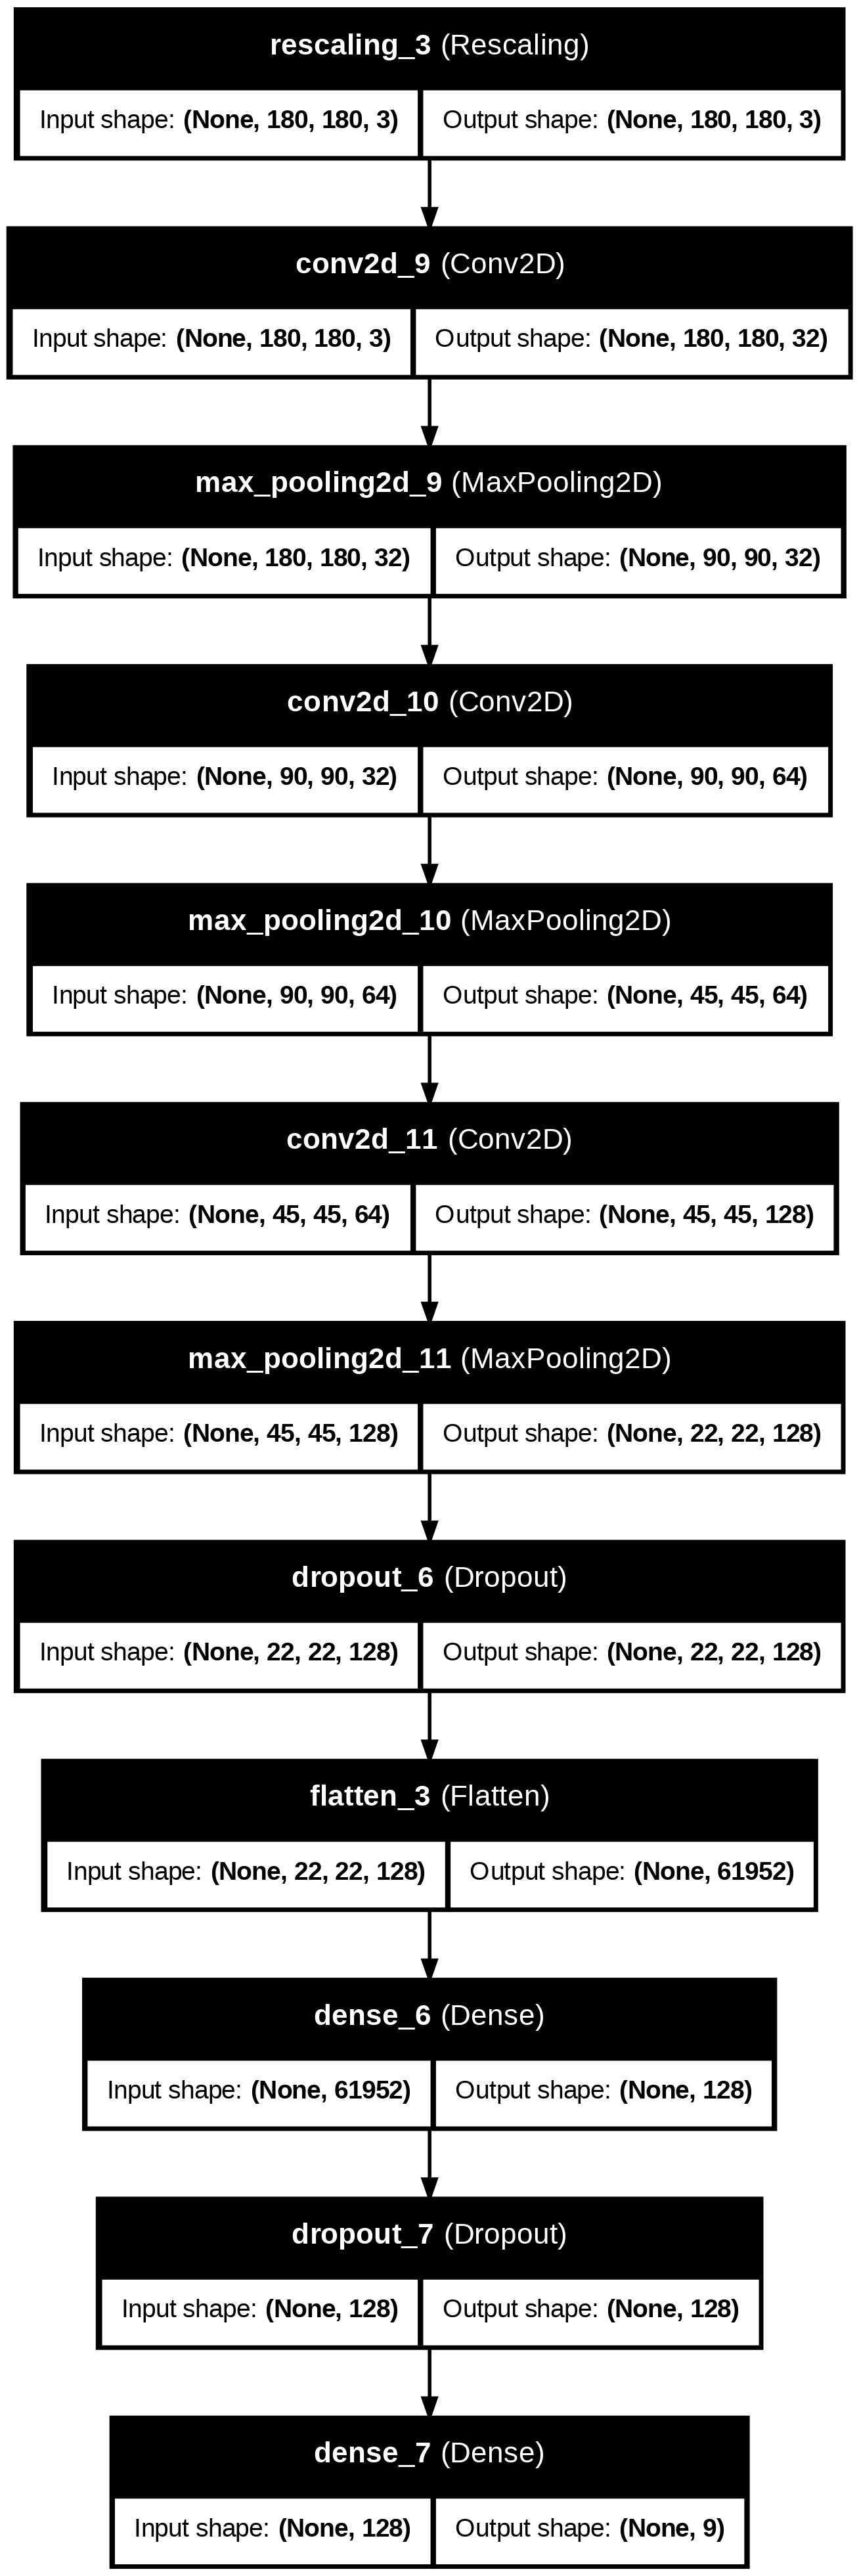

In [63]:
# vizualizing the model

plot_model(model_Augmentor, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [66]:
#train the model
epochs = 10
history_Augmentor = model_Augmentor.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 487s 3s/step - accuracy: 0.6432 - loss: 0.9882 - val_accuracy: 0.6266 - val_loss: 1.0095
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 481s 3s/step - accuracy: 0.6451 - loss: 0.9452 - val_accuracy: 0.6481 - val_loss: 0.9897
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 509s 3s/step - accuracy: 0.6748 - loss: 0.8493 - val_accuracy: 0.6800 - val_loss: 0.8983
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 519s 3s/step - accuracy: 0.7022 - loss: 0.7924 - val_accuracy: 0.7157 - val_loss: 0.7587
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 496s 3s/step - accuracy: 0.7269 - loss: 0.7060 - val_accuracy: 0.7298 - val_loss: 0.7352
Epoch 6/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 485s 3s/step - accuracy: 0.7627 - loss: 0.6313 - val_accuracy: 0.7149 - val_loss: 0.8585
Epoch 7/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 473s 3s/step - accuracy: 0.7697 - loss: 0.6269 - val_accuracy: 0.7387 - val_loss: 0.7803
Epoch 8/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 497s 3s/step - accuracy: 0.7724 - loss: 0.5807 - val_accu

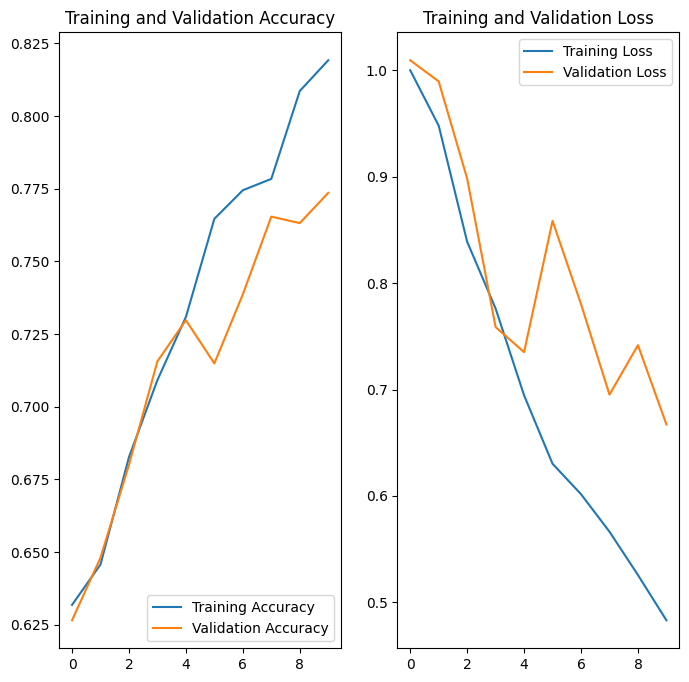

In [67]:
acc = history_Augmentor.history['accuracy']
val_acc = history_Augmentor.history['val_accuracy']

loss = history_Augmentor.history['loss']
val_loss = history_Augmentor.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observation**

Note: I have done this locally and put the result, however here due to time constraint it is still executing in google colab.

There is high train accuracy(0.82) and validation accurancy (0.77) and difference between is less
There is low train loss(0.3) and validation loss (0.65).



**However, there is still scope to reduce loss further by testing with more epochs.**
